In [1]:
# Numerical/Stats pack
import numpy as np
from collections import Counter
import math
import numpy.linalg as nl
from cvxopt import matrix, solvers

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from qiskit.visualization import plot_histogram

In [2]:
def get_basis(num_qubits, index):
    """
    Parameters
    ----------
    num_qubits : int
        number of qubits.
    index : int
        Which qubit is 1. Order follows measurement order

    Returns
    -------
    base : int
        the basis string where target position is 1
        e.g., num_qubits=5, index=1, then return '01000'

    """
    origin = list('0'*num_qubits)
    origin[index] = '1'
    return ''.join(origin)
    
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def print_info(mat):
    u, s, vh = np.linalg.svd(mean_mat-ind_mat, full_matrices=True)
    ns = np.sum(s<1e-3)
    print("Rank={:.4g} # singular value < 1e-3={:.4g}".format(np.linalg.matrix_rank(mat),ns))
    print("Inf norm={:.4g}, Frobenius norm={:.4g}, 2-Norm={:.4g}".format(np.linalg.norm(mat, ord=np.inf), 
                                                                              np.linalg.norm(mat, ord='fro'),
                                                                              np.linalg.norm(mat, ord=2)))
    print("Among {:d} entries, {:d} entries < 1e-3, {:d} entries < 1e-4, {:d} entries < 1e-6".format(mat.shape[0]*mat.shape[1],
                                                                                                      mat[np.abs(mat)<1e-3].shape[0],
                                                                                                      mat[np.abs(mat)<1e-4].shape[0], 
                                                                                                      mat[np.abs(mat)<1e-6].shape[0]))

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [4]:
# Choose machine
# file_address = "./QuitoData/" # Both machine has 5 qubits
file_address = "./LimaData/" # Both machine has 5 qubits
# file_address = './BelemData/'
num_qubits = 5

In [5]:
# Full Matrix
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/string_data.shape[0]
    
np.savetxt(file_address+"Afull.txt", mean_mat)

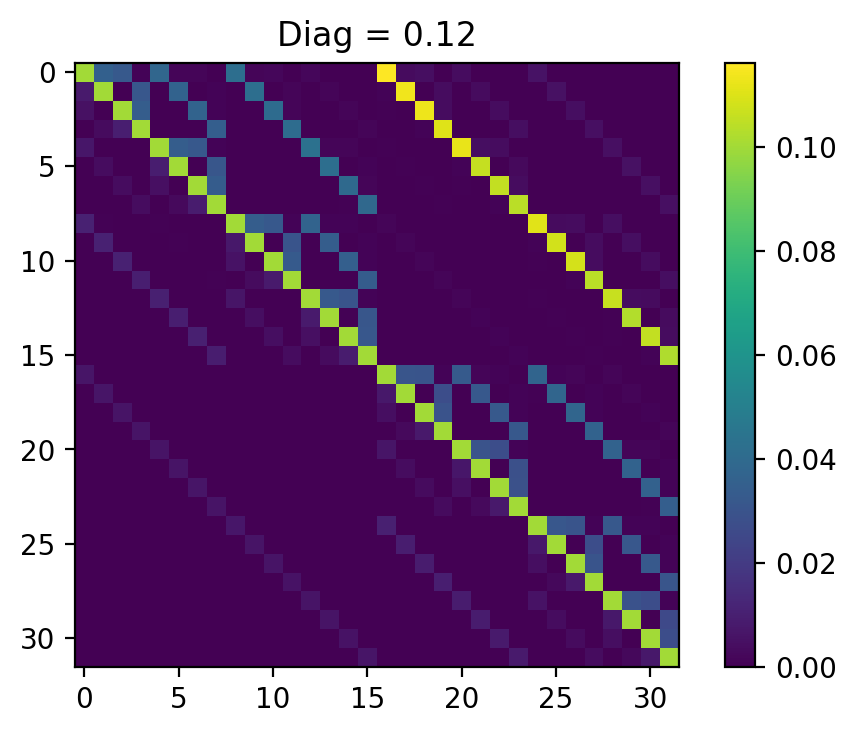

In [6]:
plt.rcParams["figure.dpi"] = 200
small_diag = np.copy(mean_mat)
for i in range(2**num_qubits):
    small_diag[i,i] = 0.1

plt.imshow(small_diag)
plt.colorbar()
plt.title("Diag = 0.12")
plt.show()

# $$A_{full} = A_{ind} + A_{mask}$$
# $$ A_{mask} = A_{full} - A_{ind}$$

## where each entry in $A_{mask}$ ideally should close to 0.

# Method 0 Optimization

##  Lima 


Rank=31 # singular value < 1e-3=9

Inf norm=0.01033, Frobenius norm=0.01442, 2-Norm=0.005208

Among 1024 entries, 970 entries < 1e-3, 767 entries < 1e-4, 217 entries < 1e-6

## Quito

Rank=31 # singular value < 1e-3=8

Inf norm=0.01459, Frobenius norm=0.01665, 2-Norm=0.008092

Among 1024 entries, 967 entries < 1e-3, 721 entries < 1e-4, 182 entries < 1e-6


## Belem

Rank=31 # singular value < 1e-3=8

Inf norm=0.01111, Frobenius norm=0.01735, 2-Norm=0.006085

Among 1024 entries, 948 entries < 1e-3, 746 entries < 1e-4, 185 entries < 1e-6

# Method 2

For example, if we have 5 qubits and we compute Pr(0|0) for Qubit 1, then we go to **data from circuit that constructs 10111** and have $$ Pr(0|0) = \frac{m(10111)}{m(10111) + m(11111)}, $$ where $m()$ is the number of appearences of a given base in some dataset.

Similarly, if we compute Pr(1|1) for Qubit 1, then we go to **data from circuit that constructs 01000** and have $$ Pr(1|1) = \frac{m(01000)}{m(01000) + m(00000)}. $$

So we need $2n$ number of circuits where $n$ is the number of qubits. (~60000 measurements for 1 probability)


 ## Lima

Difference between full matrix and the matrix from this method:


Rank=31 # singular value < 1e-3=9

Inf norm=0.01047, Frobenius norm=0.01927, 2-Norm=0.007424

Among 1024 entries, 956 entries < 1e-3, 762 entries < 1e-4, 227 entries < 1e-6


### use first 25% data

Inf norm=0.01801, Frobenius norm=0.03068, 2-Norm=0.0107

Among 1024 entries, 927 entries < 1e-3, 747 entries < 1e-4, 233 entries < 1e-6


## Quito

Rank=31 # singular value < 1e-3=8

Inf norm=0.01774, Frobenius norm=0.0245, 2-Norm=0.01069

Among 1024 entries, 942 entries < 1e-3, 739 entries < 1e-4, 203 entries < 1e-6


### use first 25% data
Inf norm=0.02356, Frobenius norm=0.04237, 2-Norm=0.0156

Among 1024 entries, 913 entries < 1e-3, 708 entries < 1e-4, 201 entries < 1e-6


## Belem

Rank=31 # singular value < 1e-3=8

Inf norm=0.01527, Frobenius norm=0.02253, 2-Norm=0.008683

Among 1024 entries, 948 entries < 1e-3, 751 entries < 1e-4, 192 entries < 1e-6



### use first 25% data
Inf norm=0.01898, Frobenius norm=0.03147, 2-Norm=0.0102

Among 1024 entries, 910 entries < 1e-3, 705 entries < 1e-4, 212 entries < 1e-6

In [7]:
p0m0 = np.zeros(num_qubits) # Record probability of prepare 0 measure 0
p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


for index in range(num_qubits):
    # Read data
    temp_string = get_basis(num_qubits, index)
    target = ''.join('1' if s == '0' else '0' for s in temp_string) # Corresponding bit string
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
#     string_data = string_data[:int(string_data.shape[0]/4)]
    # Record number of 1's when other qubits is noise-free
    num_data = 0
    num_0 = 0
    for bits in string_data:
        others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
        if others == '1'*(num_qubits-1): # Make sure other qubits is noise-free
            num_data += 1
            if bits[index] == '0':
                num_0 += 1
                
    # Record data
    p0m0[index] = num_0/num_data
    p0m0_total[index] = num_data
    
    
p1m1 = np.zeros(num_qubits) # Record probability of prepare 1 measure 1
p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


for index in range(num_qubits):
    # Read data
    target = get_basis(num_qubits, index) # Corresponding bit string
    string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
#     string_data = string_data[:int(string_data.shape[0]/4)]
    # Record number of 1's when other qubits is noise-free
    num_data = 0
    num_1 = 0
    for bits in string_data:
        others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
        if others == '0'*(num_qubits-1): # Make sure other qubits is noise-free
            num_data += 1
            if bits[index] == '1':
                num_1 += 1
                
    # Record data
    p1m1[index] = num_1/num_data
    p1m1_total[index] = num_data

# Method 3

Use all possible basis circuits

So we need $2^n$ number of circuits where $n$ is the number of qubits. (~900,000 measurements for 1 probability)

 
## Lima

Difference between full matrix and the matrix from this method:

Inf norm=0.01053, Frobenius norm=0.01495, 2-Norm=0.005593

Among 1024 entries, 979 entries < 1e-3, 764 entries < 1e-4, 220 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.01956, Frobenius norm=0.04031, 2-Norm=0.01378

Among 1024 entries, 904 entries < 1e-3, 723 entries < 1e-4, 205 entries < 1e-6


## Quito

Inf norm=0.01569, Frobenius norm=0.01722, 2-Norm=0.008856

Among 1024 entries, 965 entries < 1e-3, 727 entries < 1e-4, 191 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.02044, Frobenius norm=0.03067, 2-Norm=0.01026

Among 1024 entries, 932 entries < 1e-3, 709 entries < 1e-4, 184 entries < 1e-6




## Belem

Inf norm=0.01126, Frobenius norm=0.01798, 2-Norm=0.006482

Among 1024 entries, 952 entries < 1e-3, 751 entries < 1e-4, 185 entries < 1e-6

### Use 560,000 measurements for 1 Prob

Inf norm=0.0179, Frobenius norm=0.03217, 2-Norm=0.01091

Among 1024 entries, 898 entries < 1e-3, 715 entries < 1e-4, 206 entries < 1e-6

In [8]:
# p0m0_count = np.zeros(num_qubits) # Record counts of prepare 0 measure 0
# p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors
# p1m1_count = np.zeros(num_qubits) # Record counts of prepare 1 measure 1
# p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors

# # Go through all possibile basis datasets
# for bn in range(2**num_qubits):
#     target = format(bn, "0{:d}b".format(num_qubits))
#     string_data = np.genfromtxt(file_address + 'Basis'+target+'.csv', delimiter=',',dtype=np.str)
# #     string_data = string_data[:4000]
    
#     # Then for each data (bitstring) in the dataset
#     for meas_res in string_data:
#         meas_int = int(meas_res, 2) # to binary number
#         if meas_res == target: # If there is no error
#             for i in range(num_qubits):
#                 if int(target[i],2): # if bit is 1
#                     p1m1_count[i] += 1
#                     p1m1_total[i] += 1
#                 else:
#                     p0m0_count[i] += 1
#                     p0m0_total[i] += 1
        
#         if differAtOneBitPos(bn, meas_int): # if given basis and measured basis only differ by 1 bit
#             diff_pos = num_qubits - posOfRightMostDiffBit(bn, meas_int) - 1 # position that the bit is different
#             if target[diff_pos] == '0':
#                 p0m0_total[diff_pos] += 1
#             else:
#                 p1m1_total[diff_pos] += 1
            
# # Record probability of prepare 0 measure 0
# p0m0 = p0m0_count/p0m0_total
# # Record probability of prepare 1 measure 1
# p1m1 = p1m1_count/p1m1_total

In [9]:
((p0m0)/( p1m1)).mean()

1.0514788393280914

In [10]:
p0m0, p0m0_total, p1m1, p1m1_total

(array([0.99218625, 0.98930616, 0.99532829, 0.99675686, 0.99053479]),
 array([56055., 51712., 51373., 51185., 51029.]),
 array([0.87969949, 0.95691564, 0.96029957, 0.96662254, 0.96353269]),
 array([63358., 63689., 63425., 63456., 63838.]))

In [11]:
# Construct 5 matrices
single_qubit_mats = qubit_matrix(p0m0,p1m1)
single_qubit_mats

array([[[0.99218625, 0.12030051],
        [0.00781375, 0.87969949]],

       [[0.98930616, 0.04308436],
        [0.01069384, 0.95691564]],

       [[0.99532829, 0.03970043],
        [0.00467171, 0.96029957]],

       [[0.99675686, 0.03337746],
        [0.00324314, 0.96662254]],

       [[0.99053479, 0.03646731],
        [0.00946521, 0.96353269]]])

In [12]:
# matrix with independent assumption
ind_mat = single_qubit_mats[0]
for i in range(1,num_qubits):
    ind_mat = np.kron(ind_mat, single_qubit_mats[i])

In [13]:
# Optimized Matrix
opt_params = np.genfromtxt(file_address + 'Aopt.txt', delimiter=',',dtype=np.float64)
opt_p0m0 = opt_params[0:num_qubits]
opt_p1m1 = opt_params[num_qubits:2*num_qubits]
single_opt_mats = qubit_matrix(opt_p0m0,opt_p1m1)

opt_mat = single_opt_mats[0]
for i in range(1,num_qubits):
    opt_mat = np.kron(opt_mat, single_opt_mats[i])

In [14]:
print("A_full - A_ind")
print_info(mean_mat - ind_mat)
print("A_full - A_opt")
print_info(mean_mat - opt_mat)

A_full - A_ind
Rank=31 # singular value < 1e-3=9
Inf norm=0.01047, Frobenius norm=0.01927, 2-Norm=0.007424
Among 1024 entries, 956 entries < 1e-3, 762 entries < 1e-4, 227 entries < 1e-6
A_full - A_opt
Rank=31 # singular value < 1e-3=9
Inf norm=0.01033, Frobenius norm=0.01442, 2-Norm=0.005208
Among 1024 entries, 970 entries < 1e-3, 767 entries < 1e-4, 217 entries < 1e-6


In [15]:
u, s, vh = np.linalg.svd(mean_mat - opt_mat, full_matrices=True)
s

array([5.20792698e-03, 5.03936786e-03, 4.96474314e-03, 4.20036391e-03,
       4.11563255e-03, 3.57291731e-03, 3.31362232e-03, 3.26340391e-03,
       3.00291363e-03, 2.87421945e-03, 2.60826616e-03, 2.50122153e-03,
       2.30430513e-03, 2.21549541e-03, 1.97502965e-03, 1.89656382e-03,
       1.79616098e-03, 1.58317362e-03, 1.27762878e-03, 1.27258777e-03,
       1.17124519e-03, 9.81395679e-04, 9.30599286e-04, 6.97595734e-04,
       5.82057086e-04, 5.06161824e-04, 4.53156682e-04, 3.36787009e-04,
       1.59854275e-04, 1.07103163e-04, 3.65920322e-05, 1.79053857e-18])

In [16]:
# Check singular values
u, s, vh = np.linalg.svd(mean_mat-ind_mat, full_matrices=True)
s

array([7.42359533e-03, 6.88483612e-03, 6.56110504e-03, 5.94205779e-03,
       5.81794328e-03, 4.78779823e-03, 4.52991371e-03, 4.09232483e-03,
       3.77846736e-03, 3.73031368e-03, 3.26260214e-03, 3.14207210e-03,
       3.01784488e-03, 2.79136298e-03, 2.64626897e-03, 2.42353348e-03,
       1.91739169e-03, 1.76374612e-03, 1.69187669e-03, 1.38364491e-03,
       1.24905572e-03, 1.15626502e-03, 1.03840878e-03, 8.70723027e-04,
       8.42824028e-04, 5.50553227e-04, 5.44591961e-04, 4.98534628e-04,
       3.31597273e-04, 1.44960842e-04, 7.73762037e-05, 7.40790431e-18])

Rank=31 # singular value < 1e-3=9
Inf norm=0.01047, Frobenius norm=0.01927, 2-Norm=0.007424
Among 1024 entries, 956 entries < 1e-3, 762 entries < 1e-4, 227 entries < 1e-6


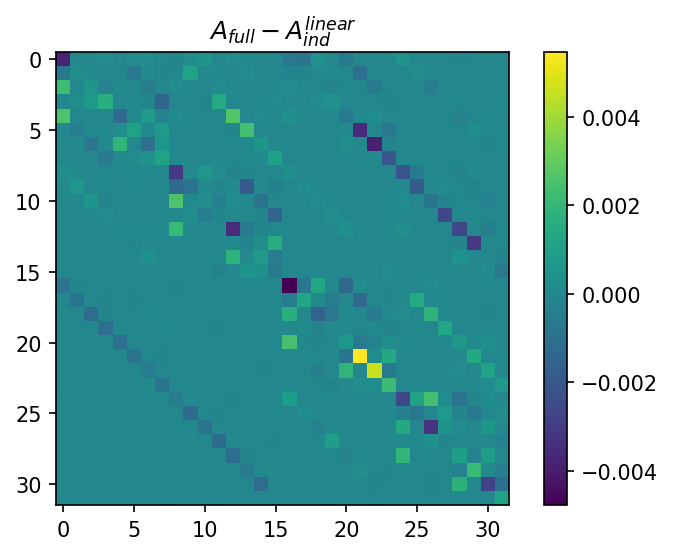

In [17]:
# plt.rcParams["figure.figsize"] = (10, 11)
plt.rcParams["figure.dpi"] = 150

# Differences
diff_mat = mean_mat - ind_mat
print_info(diff_mat)

# for i in range(2**num_qubits):
#     diff_mat[i,i] = 0

plt.imshow(diff_mat)
plt.colorbar()
plt.title("$A_{full} - A_{ind}^{linear}$")
plt.show()

Rank=31 # singular value < 1e-3=9
Inf norm=0.01033, Frobenius norm=0.01442, 2-Norm=0.005208
Among 1024 entries, 970 entries < 1e-3, 767 entries < 1e-4, 217 entries < 1e-6


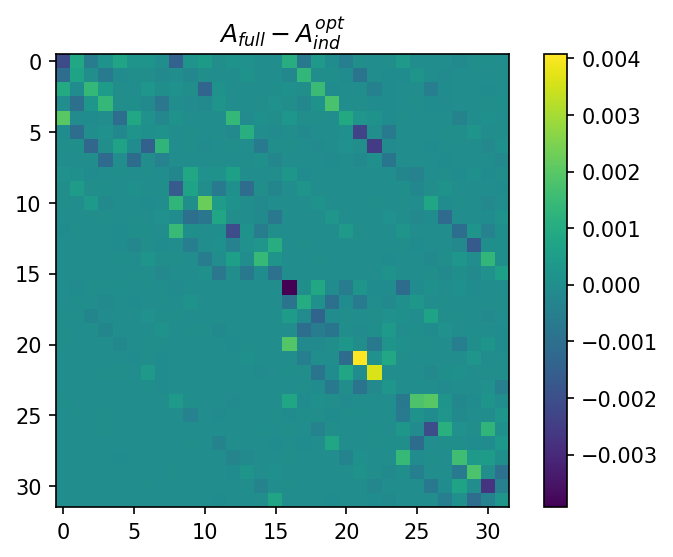

In [18]:
print_info(mean_mat - opt_mat)
plt.imshow(mean_mat - opt_mat)
plt.colorbar()
plt.title("$A_{full} - A_{ind}^{opt}$")
plt.show()

In [19]:
# Check singular values
u, s, vh = np.linalg.svd(mean_mat -  ind_mat, full_matrices=True)
s

array([7.42359533e-03, 6.88483612e-03, 6.56110504e-03, 5.94205779e-03,
       5.81794328e-03, 4.78779823e-03, 4.52991371e-03, 4.09232483e-03,
       3.77846736e-03, 3.73031368e-03, 3.26260214e-03, 3.14207210e-03,
       3.01784488e-03, 2.79136298e-03, 2.64626897e-03, 2.42353348e-03,
       1.91739169e-03, 1.76374612e-03, 1.69187669e-03, 1.38364491e-03,
       1.24905572e-03, 1.15626502e-03, 1.03840878e-03, 8.70723027e-04,
       8.42824028e-04, 5.50553227e-04, 5.44591961e-04, 4.98534628e-04,
       3.31597273e-04, 1.44960842e-04, 7.73762037e-05, 7.40790431e-18])

In [20]:
# Choose largest several components 
num_comp = num_qubits
red_diff = np.dot(np.dot(u[:,0:num_comp],np.diag(s[0:num_comp])),vh[0:num_comp])
red_mat = ind_mat + red_diff
print_info(mean_mat -  red_mat)

print_info(mean_mat -  ind_mat)

Rank=26 # singular value < 1e-3=9
Inf norm=0.00924, Frobenius norm=0.01252, 2-Norm=0.004788
Among 1024 entries, 978 entries < 1e-3, 630 entries < 1e-4, 34 entries < 1e-6
Rank=31 # singular value < 1e-3=9
Inf norm=0.01047, Frobenius norm=0.01927, 2-Norm=0.007424
Among 1024 entries, 956 entries < 1e-3, 762 entries < 1e-4, 227 entries < 1e-6


In [21]:
def find_least_norm(nQubits, ptilde):
    # Formulation
    Q = 2 * matrix(np.identity(2**nQubits))
    p = -2 * matrix(ptilde)

    G = -matrix(np.identity(2**nQubits))
    h = matrix(np.zeros(2**nQubits))

    A = matrix(np.ones(2**nQubits), (1, 2**nQubits))
    b = matrix(1.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h, A, b)
    return sol['status'], sol['x']


# def dictToVec(nQubits, counts):
#     vec = np.zeros(2**nQubits)
#     form = "{0:0" + str(nQubits) + "b}"
#     for i in range(2**nQubits):
#         key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
#                              # and delete variable form
#         if key in counts.keys():
#             vec[i] = int(counts[key])
#         else:
#             vec[i] = 0
#     return vec


def vecToDict(nQubits, shots, vec):
    counts = {}
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i)
        counts[key] = int(vec[i] * shots)
    return counts

def meas_dist(true_probs, real_counts):
    total_counts = sum(real_counts.values())
    counts_off = 0
    for key in real_counts:
        counts_off += np.abs(real_counts[key] - true_probs[int(key,2)]*total_counts)
        
    return counts_off/total_counts

Qubit 4
Given Lambdas [0.9176 0.9482]
Final Accepted Posterior Lambdas
M: 146.953 Maximizer: 0.585359 pi_obs = 220.997 pi_Q(prior) = 1.50386
Progress: 99.997%
Accepted Number N: 255, fraction 0.006
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94985056 0.78050973]
Posterior Lambda Mode [0.9773952 0.8055227]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00921098
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


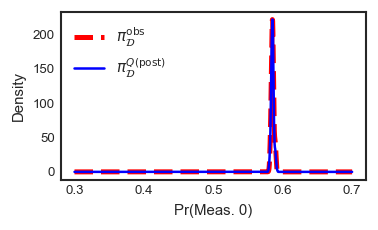

Qubit 3
Given Lambdas [0.953  0.9685]
Final Accepted Posterior Lambdas
M: 20.3401 Maximizer: 0.49755 pi_obs = 181.734 pi_Q(prior) = 8.93478
Progress: 99.997%
Accepted Number N: 2044, fraction 0.051
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.92458436 0.92664258]
Posterior Lambda Mode [0.95612071 0.95976968]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00376931
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


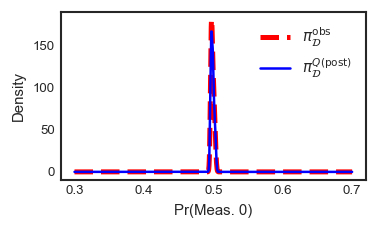

Qubit 2
Given Lambdas [0.9648 0.9785]
Final Accepted Posterior Lambdas
M: 52.3171 Maximizer: 0.549455 pi_obs = 219.347 pi_Q(prior) = 4.19263
Progress: 99.997%
Accepted Number N: 749, fraction 0.019
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.95005163 0.85074478]
Posterior Lambda Mode [0.98014311 0.87751527]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00931186
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


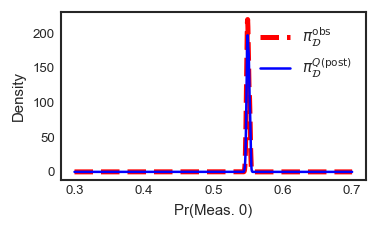

Qubit 1
Given Lambdas [0.974  0.9846]
Final Accepted Posterior Lambdas
M: 23.6256 Maximizer: 0.526253 pi_obs = 170.471 pi_Q(prior) = 7.21553
Progress: 99.997%
Accepted Number N: 1731, fraction 0.043
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94606311 0.8920298 ]
Posterior Lambda Mode [0.97597809 0.92100283]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00152941
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


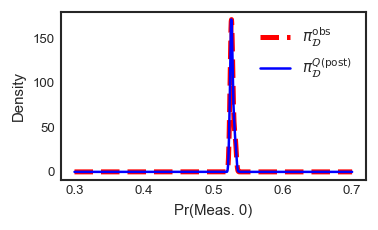

Qubit 0
Given Lambdas [0.9656 0.9763]
Final Accepted Posterior Lambdas
M: 38.5268 Maximizer: 0.538654 pi_obs = 213.941 pi_Q(prior) = 5.55305
Progress: 99.997%
Accepted Number N: 1046, fraction 0.026
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94458087 0.86595119]
Posterior Lambda Mode [0.96587945 0.89438774]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00550024
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


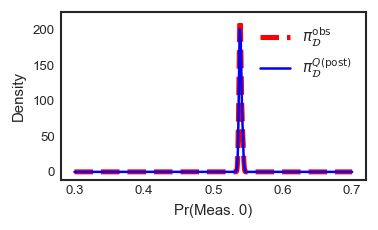

In [22]:
import sys
sys.path.insert(1, 'Scripts')
import measfilter as mf
ind_filter = mf.MeasFilter([4, 3, 2, 1,0], file_address=file_address)
ind_filter.inference(seed=14687,show_denoised=False,shots_per_point=8192)

In [30]:
# Add A_mask to A_ind estimated by consistent Bayesian
red_mat = ind_filter.mat_mean + (mean_mat -  opt_mat)

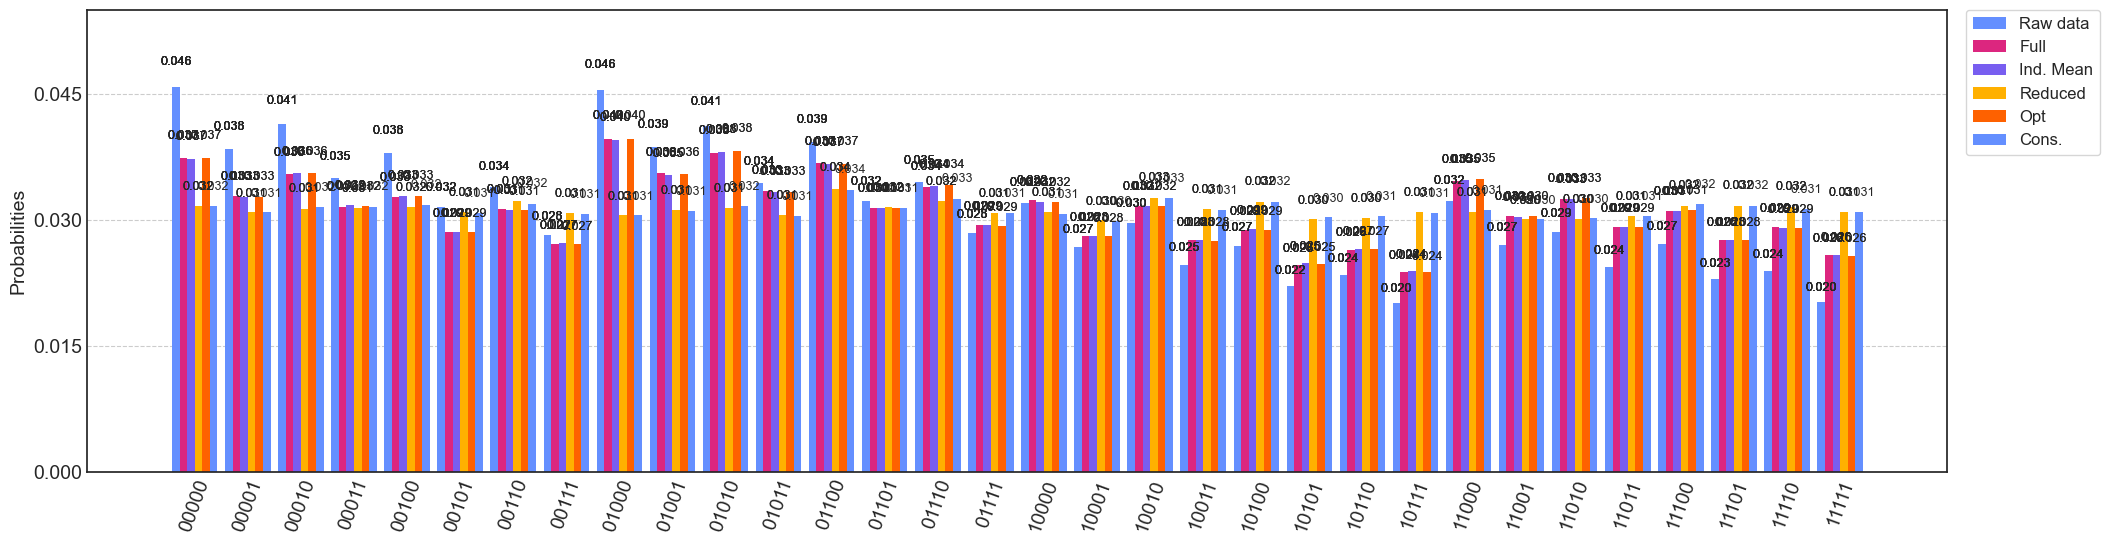

In [31]:
shots = 8192
had_strings = np.genfromtxt(file_address + 'Had.csv', delimiter=',',dtype=np.str)
real_counts = Counter(had_strings)
real_vec = dictToVec(num_qubits,real_counts)/(shots*64)

full_status, full_vec = find_least_norm(num_qubits, nl.solve(mean_mat, real_vec))
full_counts = vecToDict(num_qubits, shots*64, full_vec)

ind_status, ind_vec = find_least_norm(num_qubits, nl.solve(ind_mat, real_vec))
ind_counts = vecToDict(num_qubits, shots*64, ind_vec)

red_status, red_vec = find_least_norm(num_qubits, nl.solve(red_mat, real_vec))
red_counts = vecToDict(num_qubits, shots*64, red_vec)

con_counts = ind_filter.filter_mean(real_counts)

opt_status, opt_vec = find_least_norm(num_qubits, nl.solve(opt_mat, real_vec))
opt_counts = vecToDict(num_qubits, shots*64, opt_vec)

legend = ["Raw data", "Full",  "Ind. Mean", "Reduced", "Opt", "Cons."]
plot_histogram([real_counts, full_counts, ind_counts, red_counts, opt_counts, con_counts], legend=legend,  figsize=(24, 6))

In [32]:
had_probs = [1/2**num_qubits]*(2**num_qubits)
print("Raw: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, real_counts)))
print("Full A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, full_counts)))
print("Ind. Mean: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, ind_counts)))
print("Opt. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, opt_counts)))
print("Cons. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, con_counts)))
print("Red. A: total probalities dist from true = {:.6g}".format(meas_dist(had_probs, red_counts)))

Raw: total probalities dist from true = 0.189915
Full A: total probalities dist from true = 0.101403
Ind. Mean: total probalities dist from true = 0.100349
Opt. A: total probalities dist from true = 0.102047
Cons. A: total probalities dist from true = 0.0205885
Red. A: total probalities dist from true = 0.0198656
